# Logistic Regression

## 1 Logistic regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.

Suppose that you are the administrator of a university department and
you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision.

Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams.

### 1.1 Visualizing the data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')
%matplotlib inline
from scipy.optimize import fmin_bfgs, minimize
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('ex2data1.txt', header=None)
df.rename(columns={0: 'exam1', 
                   1: 'exam2',
                   2: 'accepted'}, inplace=True)
df.head()

,exam1,exam2,accepted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


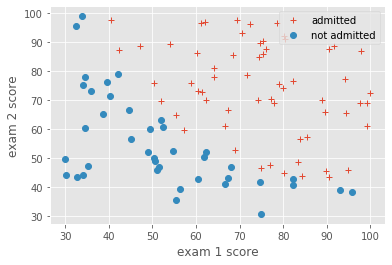

In [3]:
accepted_students = df[df.accepted==1]
others = df[df.accepted==0]
plt.plot(accepted_students.exam1, accepted_students.exam2, 
         marker='+', linestyle='None', label='admitted')
plt.plot(others.exam1, others.exam2,
        marker='o', linestyle='None', label='not admitted')
plt.xlabel('exam 1 score')
plt.ylabel('exam 2 score')
plt.legend(loc='upper right')
plt.show()

### 1.2  Implementation

Logistic regression hypothesis is defined as:
$$ h_{\theta}(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function defined as:
$$ g(z) = \frac{1}{1+e^{-z}} $$

Cost function in logistic regression is (no regularization parameter):
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}\log(h_{\theta}(x^{i})) - (1-y^{(i)})\log(1-h_{\theta}(x^{i}))] $$

and the gradient of regularizationthe cost is a vector of the same length as $ \theta $ where the $ j^{th} $ element (for $ j $ = 0, 1, ..., n) is defined as follows:
$$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)} $$

In [4]:
def normalize(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    x = (x-mu)/sigma
    return mu, sigma, x

def sigmoid(z):
    return 1/(1 + np.exp(-1 * z))

def costFunc(theta, X, y):
    m = len(y)
    p_y = X @ theta.reshape(-1,1)
    J = np.mean((-y * np.log(sigmoid(p_y))) - ((1-y) * np.log(1-sigmoid(p_y))))
    return J

def gradient(theta, X, y):
    m = len(y)    
    theta = theta.reshape(-1,1)
    p_y = X @ theta
    grad = 1/m * X.T @ (sigmoid(p_y) - y)
    return grad.flatten()

In [5]:
X = df[['exam1', 'exam2']].values
mu, sigma, X_norm = normalize(X)
X_bias = np.concatenate((np.ones(shape=(len(df),1)), X), axis=1)
X_norm_bias = np.concatenate((np.ones(shape=(len(df),1)), X_norm), axis=1)
y = df.accepted.values.reshape(-1,1)

In [6]:
n, m = X.shape
initial_theta = np.zeros(m+1)
cost = costFunc(initial_theta, X_bias, y)
grad = gradient(initial_theta, X_bias, y)

In [7]:
print(f'Cost at initial theta (zeros) is {np.squeeze(cost)}')
print(f'Expected cost (approx): 0.693\n')
       
print(f'Gradient at initial theta (zeros) is \n{grad}')
print(f'Expected gradients (approx):\n -0.1000\n -12.0092\n -11.2628\n')


Cost at initial theta (zeros) is 0.6931471805599453
Expected cost (approx): 0.693

Gradient at initial theta (zeros) is 
[ -0.1        -12.00921659 -11.26284221]
Expected gradients (approx):
 -0.1000
 -12.0092
 -11.2628



Optimization, when performed using batch gradient descent method is in its vectorized form defined as:
$$ \theta := \theta - \frac{\alpha}{m} X^T (sigmoid(X\theta) - \vec{y})$$

Here, the advanced method of optimization is performed using *black box* function *fmin_bfgs* from SciPy library.
The idea is to find values $\theta$ where function $J(\theta)$ is at its optimal value. 
The *fmin_bfgs* function takes the initial values of the parameters $\theta$ we want to optimize, a function that, wen given the training set and a particular $\theta$, computes the logistic regression cost and gradient with the respect to $\theta$ for the dataset $(X, y)$ and additional arguments.

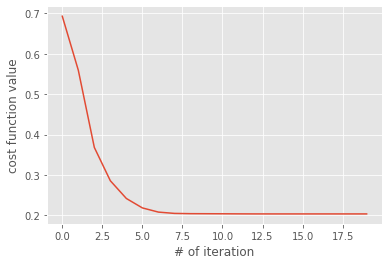

In [8]:
# optimization with normalization of data -> faster convergence
theta, theta_history = fmin_bfgs(costFunc,
                               initial_theta,
                               fprime = gradient,
                               args=(X_norm_bias,y),
                               retall = 1, 
                               disp = 0)

J = []
for i, th in enumerate(theta_history):
    J.append(costFunc(th, X_norm_bias, y))  
plt.plot(J)
plt.xlabel('# of iteration')
plt.ylabel('cost function value')
plt.show()

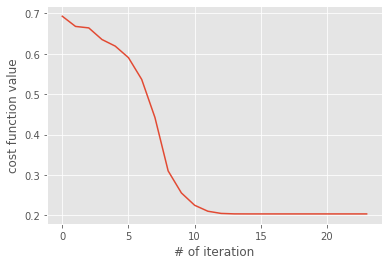

In [9]:
# optimization with no normalization
theta, theta_history = fmin_bfgs(costFunc,
                               initial_theta,
                               fprime = gradient,
                               args=(X_bias,y),
                               retall = 1, 
                               disp = 0)

J = []
for i, th in enumerate(theta_history):
    J.append(costFunc(th, X_bias, y))  
plt.plot(J)
plt.xlabel('# of iteration')
plt.ylabel('cost function value')
plt.show()

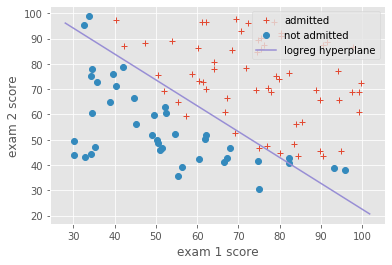

In [10]:
#decision boundary

def plotDecisionBoundary(theta, X, y):
    #plot data
    accepted_students = df[df.accepted==1]
    others = df[df.accepted==0]
    plt.plot(accepted_students.exam1, accepted_students.exam2, 
             marker='+', linestyle='None', label='admitted')
    plt.plot(others.exam1, others.exam2,
            marker='o', linestyle='None', label='not admitted')
    
    #plot boundary line
    x_boundary_line = np.linspace(min(X[:,1])-2, max(X[:,1])+2)
    y_boundary_line = (-1/theta[2])*(theta[1]*x_boundary_line + theta[0])
    plt.plot(x_boundary_line, y_boundary_line, label='logreg hyperplane')    
    
    plt.xlabel('exam 1 score')
    plt.ylabel('exam 2 score')
    plt.legend(loc='upper right')
    plt.show()
    
# theta for non-normalized data was used
plotDecisionBoundary(theta, X_bias, y)    

In [11]:
# predicting and accuracy testing
def accuracy(theta, X, y):
    m = len(X)
    p = np.zeros(shape=(m,1))
    
    for i in range(m):
        if (sigmoid(X[i,:] @ theta.reshape(-1,1)) >= 0.5):
            p[i] = 1
        else:
            p[i] = 0
    return np.mean(y==p)*100 
        
    

# student with 45 score on exam 1 and 85 score on exam 2, 
# probability prediction of admittance
prob = sigmoid(np.array([1, 45, 85]) @ theta)
print(f'For a student with scores 45 and 85, we predict an admission \
probability of {prob}')
print('Expected value: 0.775 +/- 0.002')
print()

#accuracy
acc = accuracy(theta, X_bias, y);
print(f'accuracy score = {acc}')
print(f'expected accuracy = 89.0')

For a student with scores 45 and 85, we predict an admission probability of 0.7762907240588942
Expected value: 0.775 +/- 0.002

accuracy score = 89.0
expected accuracy = 89.0


## 2 Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regressionto predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the
test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

### 2.1 Visualizing the data

In [12]:
df = pd.read_csv('ex2data2.txt', header=None)
df.rename(columns={0:'test1',
                   1:'test2',
                   2:'pass'}, inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1    118 non-null float64
test2    118 non-null float64
pass     118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


,test1,test2,pass
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [13]:
X = df[['test1', 'test2']].values
y = df['pass'].values.reshape(-1,1)

X.shape

(118, 2)

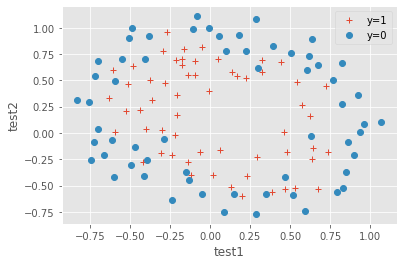

In [14]:
pos = np.where(y==1)[0]
neg = np.where(y==0)[0]

plt.plot(X[pos,0], X[pos,1], label='y=1',
        marker='+', linestyle='None')
plt.plot(X[neg,0], X[neg,1], label='y=0',
        marker='o', linestyle='None')
plt.xlabel('test1')
plt.ylabel('test2')
plt.legend(loc='best')
plt.show()

### 2.2 Feature mapping

In order to create a better fit for data, there has to be more features: in order to provide more features, feature mapping is performed.

In this case, features will be mapped into all polynomial terms of $x1$ and $x2$ (for test 1 and test 2) up to the **sixth** power.

$$
mapFeature(x) = \begin{bmatrix}
                1\\
                x_{1}\\
                x_{2}\\
                x_{1}^{2}\\
                x_{1}x_{2}\\
                x_{2}^{2}\\
                x_{1}^{3}\\
                ...\\
                x_{1}x_{2}^{5}\\
                x_{2}^{6}
                \end{bmatrix}
$$

As a result of this mapping, our vector of two features (the scores on
two QA tests) has been transformed into a 28-dimensional vector. 

A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier, it also prone to overfitting.

In [15]:
def mapFeature(X, degree=6):
    x1 = X[:,0]
    x2 = X[:,1]
    x1.shape = (x1.size,1)
    x2.shape = (x2.size,1)
    X = np.ones((x1.size,1))
    for i in range(1, degree+1):
        for j in range(i+1):
            X = np.append(X, x1**(i-j) * x2**j, axis=1)
    return X

In [16]:
degree = 6
X = mapFeature(X, degree)

### 2.3 Cost function and gradient

Regularized cost function in logistic regression is:

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}\log(h_{\theta}(x^{(i)})) - (1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

where hypothesis is the same sigmoid activation function as in non-regularized logistic regression. 
The only new parameter is the regularized parameter $\lambda$.

Gradient of the cost is a vector of the same length as $ \theta $ where the $ j^{th} $ element (for $ j $ = 0, 1, ..., n) is defined as follows:
$$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)};  j=0$$
and
$$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)} + \frac{\lambda}{m}\theta_{j};  j\geq0$$


In [17]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def costFuncReg(theta, X, y, _lambda):
    m = len(y)
    theta = theta.reshape(-1,1)
       
    p_y = X @ theta
    J = np.mean((-y * np.log(sigmoid(p_y))) - ((1-y) * np.log(1-sigmoid(p_y))))
   
    J_reg = J + (_lambda/(2*m) * np.sum(np.square(theta[1:])))
    return J_reg

def gradientReg(theta, X, y, _lambda):
    m = len(y)
    theta = theta.reshape(-1,1)
    
    p_y = X @ theta
    grad = 1/m * X.T @ (sigmoid(p_y) - y)
    
    grad[1:] = grad[1:] + (_lambda * theta[1:,] / m)
    return grad.flatten()
    
def accuracy(theta, X, y):
    m = len(X)
    p = np.zeros(shape=(m,1))
    
    for i in range(m):
        if (sigmoid(X[i,:] @ theta.reshape(-1,1)) >= 0.5):
            p[i] = 1
        else:
            p[i] = 0
    return np.mean(y==p)*100 

def prediction(theta, x, degree=6):
    theta = theta.reshape(-1,1)
    x.shape = (1,x.shape[0])
    X = mapFeature(x, degree)
    pred = sigmoid(X @ theta)
    return pred

In [18]:
n, m = X.shape
initial_theta = np.zeros(m)

_lambda = 1000
cost = costFuncReg(initial_theta, X, y, _lambda)
grad = gradientReg(initial_theta, X, y, _lambda)

In [19]:
print(f'Cost at initial theta (zeros) and lambda=1 is {np.squeeze(cost)}')
print(f'Expected cost (approx): 0.693\n')
       
print(f'Gradient at initial theta (zeros) and lambda=1 is (first five values) \n{grad[:6]}')
print(f'Expected gradients (first five values, app rox):[0.0085 0.0188 0.0001 0.0503 0.0115]')

Cost at initial theta (zeros) and lambda=1 is 0.6931471805599454
Expected cost (approx): 0.693

Gradient at initial theta (zeros) and lambda=1 is (first five values) 
[8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02 3.76648474e-02]
Expected gradients (first five values, app rox):[0.0085 0.0188 0.0001 0.0503 0.0115]


Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48


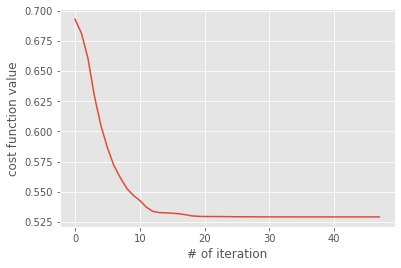

In [20]:
# optimization
_lambda = 1
theta, theta_history = fmin_bfgs(costFuncReg,
                               initial_theta,
                               fprime = gradientReg,
                               args=(X,y,_lambda),
                               retall = 1,
                               maxiter = 400)

J = []
for i, th in enumerate(theta_history):
    J.append(costFuncReg(th, X, y, _lambda))  
plt.plot(J)
plt.xlabel('# of iteration')
plt.ylabel('cost function value')
plt.show()

In [21]:
#accuracy
acc = accuracy(theta, X, y);
print(f'accuracy score: {acc}')
print(f'expected accuracy (for lambda = 1): 83.1')

accuracy score: 83.05084745762711
expected accuracy (for lambda = 1): 83.1


### 2.4 Plotting the decision boundary

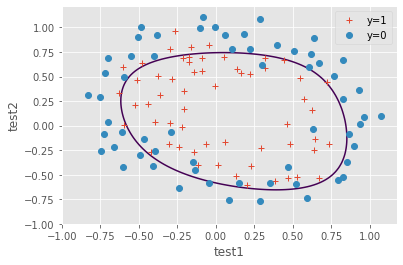

In [22]:
#decision boundary
def plotDecisionBoundary(X, y, _lambda):
    #acquire theta
    theta, theta_history = fmin_bfgs(costFuncReg,
                               initial_theta,
                               fprime = gradientReg,
                               args=(X,y,_lambda),
                               retall = 1,
                               disp = 0,
                               maxiter = 400)
    
    #plot data
    pos = np.where(y==1)[0]
    neg = np.where(y==0)[0]

    plt.plot(X[pos,1], X[pos,2], label='y=1',
            marker='+', linestyle='None')
    plt.plot(X[neg,1], X[neg,2], label='y=0',
            marker='o', linestyle='None')

    #plot boundary line
    x1 = np.linspace(-1,1,100)
    x2 = np.linspace(-1,1,100)
    y_predictions = np.empty((100,100))
    for i, _x1 in enumerate(x1):
        for j, _x2 in enumerate(x2):
            X = np.array([_x1,_x2])
            y_predictions[i,j] = prediction(theta, X, degree=6)
    plt.contour(x1, x2, y_predictions, [0.5])
   
    plt.xlabel('test1')
    plt.ylabel('test2')
    plt.legend(loc='best')
    
# theta for non-normalized data was used
plotDecisionBoundary(X, y, _lambda=1) 
plt.show()

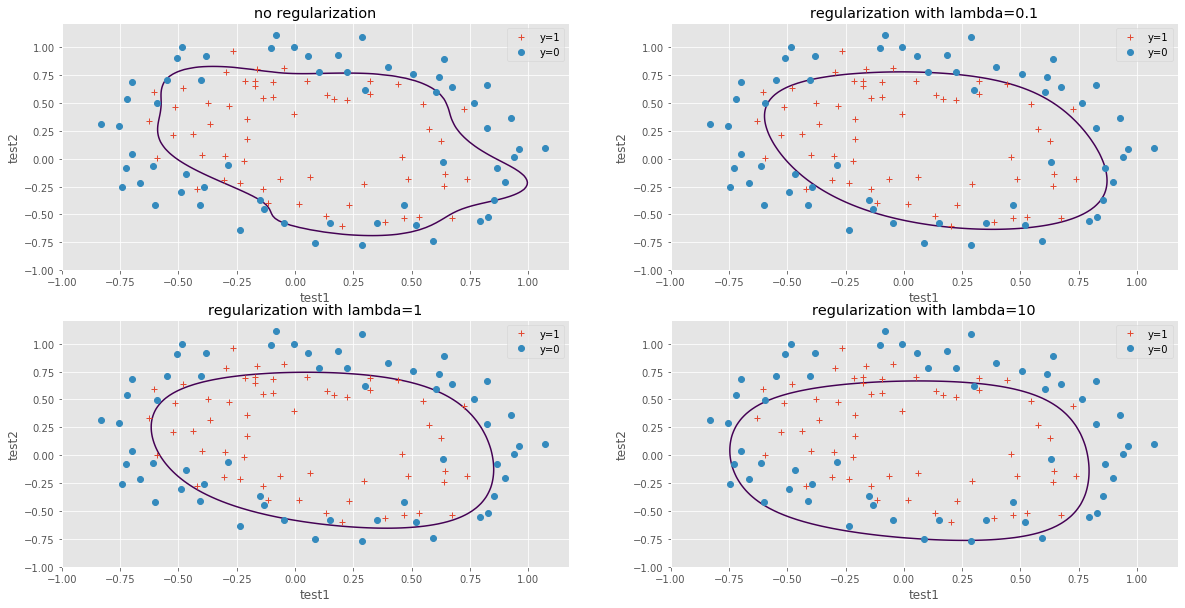

In [23]:
%matplotlib inline
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plotDecisionBoundary(X, y, _lambda=0) 
plt.title(f'no regularization')

plt.subplot(2,2,2)
plotDecisionBoundary(X, y, _lambda=0.1) 
plt.title(f'regularization with lambda=0.1')

plt.subplot(2,2,3)
plotDecisionBoundary(X, y, _lambda=1) 
plt.title(f'regularization with lambda=1')

plt.subplot(2,2,4)
plotDecisionBoundary(X, y, _lambda=10) 
plt.title(f'regularization with lambda=10')
plt.show()